## Rankability Predicting Sensitivity
### Synthetic Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import copy
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import skew

In [3]:
import sys
# We need to include the path to pyrankability. This could be different for Tim, but altneratively he could point to your copy
sys.path.insert(0,"/disk/home/jwaschur/rankability_toolbox_dev")
import pyrankability

In [4]:
sys.path.insert(0,"/disk/home/jwaschur/sensitivity_study/src")
from sensitivity_tests import *
from utilities import *
from base import *

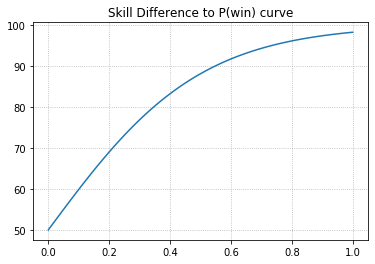

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

ELO_scale = 0.25

xs = np.linspace(0.0, 1.0, endpoint=True, num=100)
ys = sigmoid(xs/ELO_scale)*100.0

plt.grid(True, axis="both", which="both", linestyle=":")
plt.plot(xs, ys)
plt.title("Skill Difference to P(win) curve")
plt.show()

In [6]:
def generate_synth_games(n_games=748, n_teams=32, n_pts=64):
    # Columns are team1, team2, points1, points2, date
    df = {
        "team1":[],
        "team2":[],
        "team1_name":[],
        "team2_name":[],
        "points1":[],
        "points2":[]
    }
    all_teams = range(n_teams)
    all_skills = np.linspace(0.0, 1.0, endpoint=True, num=n_teams)
    for date in range(n_games):
        t1 = date % n_teams
        t2 = t1
        while t2 == t1:
            t2 = random.choice(all_teams)
        scaled_elo_diff = (all_skills[t1] - all_skills[t2])/ELO_scale
        prob_t1_win = sigmoid(scaled_elo_diff)
        t1_pts = n_pts*np.random.binomial(n=1, p=prob_t1_win)
        t2_pts = n_pts - t1_pts
        df["team1"].append(t1)
        df["team2"].append(t2)
        df["team1_name"].append(str(t1))
        df["team2_name"].append(str(t2))
        df["points1"].append(t1_pts)
        df["points2"].append(t2_pts)
    return pd.DataFrame(df)

In [7]:
games={}
years = list(range(1000))
for year in years:
    games[year] = generate_synth_games()

games[year]

,team1,team2,team1_name,team2_name,points1,points2
0,0,20,0,20,0,64
1,1,26,1,26,0,64
2,2,12,2,12,0,64
3,3,18,3,18,0,64
4,4,22,4,22,0,64
...,...,...,...,...,...,...
743,7,30,7,30,0,64
744,8,19,8,19,64,0
745,9,5,9,5,64,0
746,10,9,10,9,64,0


In [8]:
# Note to future self: Parameters from FODS paper but might need to be optimized
direct_thres = 2
spread_thres = 2
weight_indirect = 0.5
Ds = {}
#fracs = [0.5, 0.75, 1.] # 25% of total data added per step
fracs = [0.512, 0.64, 0.8, 1.] # 25% of current data added per step
#fracs = [0.8, 1.0] # simpler case
pairs = list(zip(fracs[:-1], fracs[1:]))
pair_to_predict = pairs[0]

for year in tqdm(games.keys()):
    Ds[year] = {}
    game_list = list(games[year].index)
    
    game_df = pd.DataFrame({"team1_name":games[year]['team1_name'],
                            "team1_score":games[year]['points1'],
                            "team2_name":games[year]['team2_name'],
                            "team2_score":games[year]['points2']
                           })
    for frac in fracs:
        upper = int(len(game_df)*frac)
        game_df_sample = game_df.iloc[:upper,:]
        map_func = lambda linked: support_map_vectorized_direct_indirect_weighted(linked,direct_thres=direct_thres,spread_thres=spread_thres,weight_indirect=weight_indirect)
        Ds[year][frac] = pyrankability.construct.V_count_vectorized(game_df_sample,map_func)

  0%|          | 0/1000 [00:00<?, ?it/s]/disk/home/jwaschur/rankability_toolbox_dev/pyrankability/construct.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df["game"] = list(game_df.index)
100%|██████████| 1000/1000 [18:39<00:00,  1.12s/it]


team2    0    1   10   11    12    13   14   15   16   17  ...   29     3  \
team1                                                      ...              
0      NaN  1.0  2.0  1.5   1.5   3.5  2.5  0.0  0.0  0.5  ...  0.0   2.5   
1      3.0  NaN  4.5  0.5   1.0   2.0  1.5  0.0  0.0  1.0  ...  0.0   1.5   
10     8.5  4.5  NaN  3.0   5.0   5.5  5.5  1.0  3.0  1.0  ...  0.0   5.0   
11     3.0  2.5  3.0  NaN   2.0   3.0  4.5  1.5  0.5  0.5  ...  0.0   5.0   
12     1.0  5.0  2.5  0.5   NaN   0.5  0.0  1.5  0.0  0.0  ...  0.0   6.0   
13     7.5  5.5  8.0  1.5   5.5   NaN  4.5  1.5  2.5  0.5  ...  1.0   8.5   
14     2.5  1.5  2.0  3.0   2.5   0.5  NaN  2.0  0.5  1.5  ...  0.0   4.5   
15     2.0  2.0  2.0  3.0   3.0   3.0  5.5  NaN  3.0  4.0  ...  0.0   6.0   
16     2.0  4.5  4.0  3.0   3.0   4.5  2.5  0.5  NaN  0.5  ...  0.5   1.5   
17     5.5  5.5  1.5  5.5   5.0   4.0  5.5  4.0  4.5  NaN  ...  0.0   9.0   
18     5.5  7.0  3.5  6.5   7.0   4.5  5.0  4.0  5.0  4.5  ...  0.5   8.5   

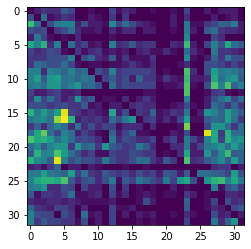

In [9]:
print(Ds[0][fracs[0]])

plt.imshow(Ds[0][fracs[0]].fillna(0))
plt.show()

In [10]:
rankings = {}
taus = {}
results = pd.DataFrame(columns=pairs+["Year"]).set_index("Year")

for year in tqdm(games.keys()):
    rankings[year] = []
    taus[year] = {}
    data = []
    for i in range(len(pairs)):
        pair = pairs[i]
        D1 = Ds[year][pair[0]]
        D2 = Ds[year][pair[1]]
        ranking1 = MasseyRankingAlgorithm().rank(D1.fillna(0).values)
        ranking2 = MasseyRankingAlgorithm().rank(D2.fillna(0).values)
        rankings[year].append((ranking1,ranking2))
        ranking1, ranking2 = rankings[year][i]
        taus[year][pair] = kendall_tau(ranking1,ranking2)
        data.append(taus[year][pair])
    results = results.append(pd.Series(data,index=results.columns,name=year))

100%|██████████| 1000/1000 [00:32<00:00, 30.51it/s]


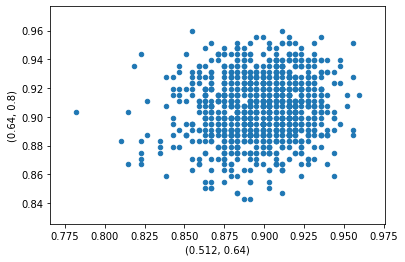

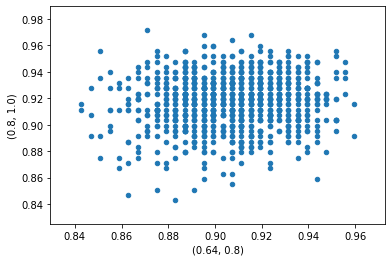

In [11]:
n_pairs = len(pairs)
corrs = []
for i in range(n_pairs-1):
    results.plot.scatter(pairs[i], pairs[i+1])

In [12]:
df_details = []
def get_rankability_results(n_restarts=250):
    df_ks = []
    df_years = []
    df_fracs = []
    df_p_stats = {}
    for year in tqdm(games.keys()):
        for pair in pairs:
            D = Ds[year][pair[0]].fillna(0)
            #C = pyrankability.construct.C_count(D,0)
            k,details = pyrankability.rank.solve(D,method='lop', num_random_restarts=n_restarts, lazy=False, cont=True)
            p_stats = get_P_stats(details["P"])
            for name, val in p_stats.items():
                if name not in df_p_stats:
                    df_p_stats[name] = []
                df_p_stats[name].append(val)
            df_ks.append(k)
            df_years.append(year)
            df_fracs.append(pair[0])
            df_details.append(details)

    results_temp = {"k":df_ks,"Year":df_years,"Fraction":df_fracs}
    for key, val in df_p_stats.items():
        if key in results_temp:
            raise ValueError("Duplicate column name! Fix collision before moving on!")
        results_temp[key] = val

    return pd.DataFrame(results_temp)

In [13]:
rankability_results = get_rankability_results()
rankability_results

  0%|          | 0/1000 [00:00<?, ?it/s]

Academic license - for non-commercial use only


 32%|███▏      | 320/1000 [10:40:03<21:35:50, 114.34s/it]

OSError: [Errno 24] Too many open files: '/dev/shm/tmp85i8idd2'

In [ ]:
for_corr = rankability_results.loc[rankability_results.Fraction==pair_to_predict[0]].set_index('Year').join(results)
for_corr

In [ ]:
for_corr.corr()

In [ ]:
pearsonr(for_corr['k'],for_corr[pair_to_predict])

In [ ]:
col_names = [
    'Year',
    '# X* frac',
    'k',
    '# X* frac top 40',
    'kendall_w',
    'p_lowerbound',
    'max_L2_dist',
    'mean_L2_dist',
    'min_tau',
    'mean_tau',
    'Pair'
]

all_score_df = pd.DataFrame(columns=col_names)

c=0
for year in tqdm(games.keys()):
    for pair in pairs:
        V = Ds[year][pair_to_predict[0]]
        rresults = rankability_results.iloc[c,:]
        k = rresults['k']
        details = df_details[c]
        x = pd.DataFrame(details['x'],index=V.index,columns=V.columns)
        r = x.sum(axis=0)
        order = np.argsort(r)
        xstar = x.iloc[order,:].iloc[:,order]
        xstar.loc[:,:] = pyrankability.common.threshold_x(xstar.values)
        inxs = np.triu_indices(len(xstar),k=1)
        xstar_upper = xstar.values[inxs[0],inxs[1]]
        nfrac_upper = sum((xstar_upper > 0) & (xstar_upper < 1))
        flat_frac = ((xstar > 0) & (xstar < 1)).sum(axis=0)
        nfrac_top_40 = flat_frac.iloc[:40].sum()
        entry_data = [
            year,
            nfrac_upper*2,
            k,
            nfrac_top_40,
            rresults["kendall_w"],
            rresults["p_lowerbound"],
            rresults["max_L2_dist"],
            rresults["mean_L2_dist"],
            rresults["min_tau"],
            rresults["mean_tau"],
            pair
        ]
        entry = pd.Series(entry_data,col_names,name=c)
        c+=1
        all_score_df = all_score_df.append(entry)
all_score_df.set_index("Year",inplace=True)

In [ ]:
all_score_df = all_score_df.loc[all_score_df.Pair == pair_to_predict].drop('Pair',axis=1).join(results)

In [ ]:
all_score_df

In [ ]:
# TODO: Save all_score_df for easy reuse
# TODO: add function to reload all_score_df from saved file
#all_score_df.to_csv("all_synth_score_df.csv")
#all_score_df = pd.read_csv("all_synth_score_df.csv")

In [ ]:
for col in all_score_df.columns:
    if col not in pairs:
        all_score_df.plot.scatter(col, pair_to_predict, title="Final Sensitivity vs " + col)

In [ ]:
import sklearn.linear_model as skl_lm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

all_feature_cols = [c for c in all_score_df.columns if c not in pairs]

def evaluate(df,pred_col=pair_to_predict,feature_cols=all_feature_cols,model=DummyRegressor(),param_grid={}):
    # fill in evaluat
    loo = LeaveOneOut()
    y = df[pred_col]
    X = df[feature_cols]
    
    grid = GridSearchCV(model,param_grid,refit=True,verbose=0, cv=3,n_jobs=-1)
    scores = cross_val_score(grid, X, y, scoring="neg_mean_absolute_error", cv=loo, n_jobs=4, verbose=1)
    return pd.Series([len(scores),np.mean(np.abs(scores)),np.std(scores)],index=["Folds","MAE","STD"])

In [ ]:
evaluate(all_score_df)

In [ ]:
evaluate(all_score_df,model=SVR(gamma='scale'),param_grid = {'C': [0.1,1,10,100], 'epsilon': [0.1,0.5,1],'kernel': ['linear', 'rbf']})